# AA228 Final Project: Lunar Lander
#### Kapil Dheeriya, Cole Robins, Ashley Davidson
Fall 2024

In [2]:
import numpy as np
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import collections
%matplotlib inline
#import torch
#run pip install gym and pip install gym[box2d] in terminal
seed_num = 42

Random Lunar Lander

In [4]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')
env.action_space.seed(seed_num)
def ll_random(env, num_iter, max_steps=1000, render=False):
    #List of total rewards over iterations
    rewards = []

    for i in range(num_iter):
        #Reset env
        obs, info = env.reset()
        iter_reward = 0
        num_steps = 0

        #Take steps until termination condition
        while num_steps < max_steps:
            #Take a step
            observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
            #Add R(s,a) to cumulative reward over an iteration
            iter_reward += reward
            #if render: env.render()
            if terminated or truncated:
                rewards.append(iter_reward)
                break
    
    return np.array(rewards)

random_trials_rewards = ll_random(env, num_iter=1000)
random_trials_mean = np.mean(random_trials_rewards)

/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


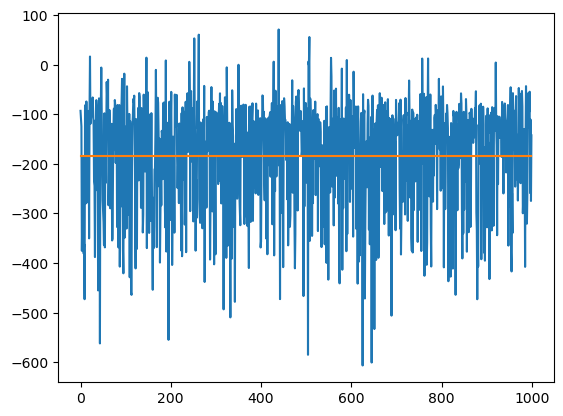

In [5]:
plt.plot(random_trials_rewards)
plt.plot([random_trials_mean] * len(random_trials_rewards))

In [6]:
def discretize(s):
    return ((s[0] + 1.5)*(10/3) // 10,
            (s[1] + 1.5)*(10/3) // 10,
            (s[2] + 5)// 10,
            (s[3] + 5)// 10,
            (10*s[4]/np.pi + 10)//10,
            (s[5] + 5)//10,
            int(s[6]),
            int(s[7]))

def epsilon_greedy(disc_state, Q, eps=0.15):
    if np.random.rand() < eps:
        return np.random.randint(0,4)
    else:
        #if Qs haven't been initialized for this state, choose to do nothing (argmax=0)
        return np.argmax(np.array([Q[disc_state+(i,)] for i in range(4)]))


def sarsa(env, alpha, num_iter, max_steps=1000):
    Q = collections.defaultdict(float)
    gamma = 0.95
    rewards = []

    for i in range(num_iter):
        obs, info = env.reset()
        d_state = discretize(obs)

        iter_reward = 0
        num_steps = 0

        #first action
        action = epsilon_greedy(d_state, Q)
        #Take steps until termination condition
        while num_steps < max_steps:
            #Take a step
            observation, reward, terminated, truncated, info = env.step(action)
            #Add R(s,a) to cumulative reward over an iteration
            iter_reward += reward
            next_state = discretize(observation)
            next_act = epsilon_greedy(next_state, Q)
            #if render: env.render()

            #Update Q value according to next state and action
            if not terminated:
                Q[d_state + (action,)] += alpha*(reward + gamma*Q[next_state+(next_act,)] - Q[d_state + (action,)])
            else:
                Q[d_state + (action,)] += alpha*(reward - Q[d_state + (action,)])
                rewards.append(iter_reward)
                break

            #update current state and action
            d_state = next_state
            action = next_act
            num_steps += 1
    return rewards, Q



In [7]:
sarsa_rewards, sarsa_Q = sarsa(env, 1E-2, 1000)
sarsa_rewards_mean = np.mean(sarsa_rewards)

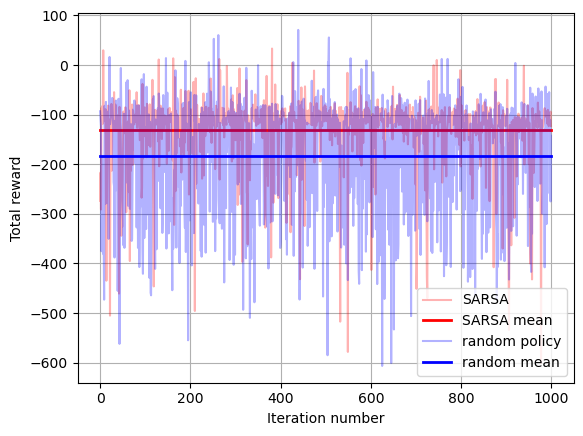

In [8]:
plt.plot(sarsa_rewards, label='SARSA', color='r', alpha=0.3)
plt.plot([sarsa_rewards_mean] * len(sarsa_rewards), label='SARSA mean', lw=2, color='r', alpha=1)
plt.plot(random_trials_rewards, label='random policy', color='b',alpha=0.3)
plt.plot([random_trials_mean] * len(random_trials_rewards), label='random mean', lw=2, color='b')
plt.grid()
plt.xlabel('Iteration number')
plt.ylabel('Total reward')
plt.legend()

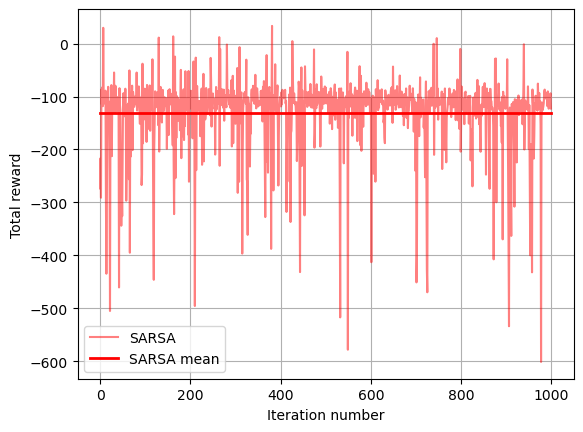

In [9]:
plt.plot(sarsa_rewards, label='SARSA', color='r', alpha=0.5)
plt.plot([sarsa_rewards_mean] * len(sarsa_rewards), label='SARSA mean', lw=2, color='r', alpha=1)
#plt.plot(random_trials_rewards, label='random policy', color='b',alpha=0.3)
#plt.plot([random_trials_mean] * len(random_trials_rewards), label='random mean', lw=2, color='b')
plt.grid()
plt.xlabel('Iteration number')
plt.ylabel('Total reward')
plt.legend()

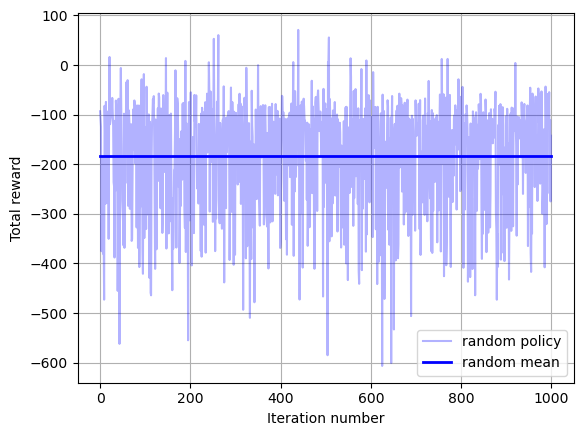

In [10]:
#plt.plot(sarsa_rewards, label='SARSA', color='r', alpha=0.5)
#plt.plot([sarsa_rewards_mean] * len(sarsa_rewards), label='SARSA mean', lw=2, color='r', alpha=1)
plt.plot(random_trials_rewards, label='random policy', color='b',alpha=0.3)
plt.plot([random_trials_mean] * len(random_trials_rewards), label='random mean', lw=2, color='b')
plt.grid()
plt.xlabel('Iteration number')
plt.ylabel('Total reward')
plt.legend()

KeyboardInterrupt: 

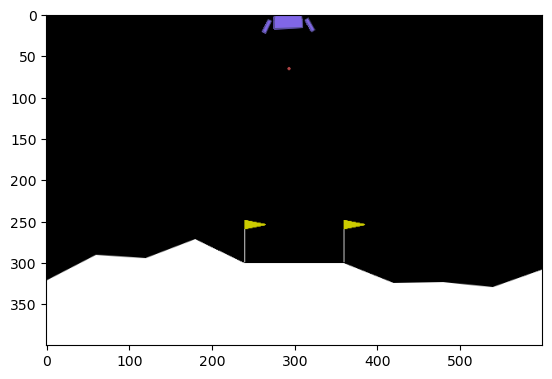

In [11]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')
env.action_space.seed(seed_num)

observation, info = env.reset(seed=seed_num)
img = plt.imshow(env.render())
for _ in range(1000):
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    if terminated or truncated:
        observation, info = env.reset()
env.close()

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Neural Network for Q-function approximation
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

# Replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# Deep Q-Learning function
def train_dqn(env, episodes, gamma=0.99, lr=1e-3, batch_size=64, buffer_capacity=100000, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.995):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    dqn = DQN(input_dim, output_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    criterion = nn.MSELoss()
    buffer = ReplayBuffer(buffer_capacity)
    epsilon = epsilon_start

    rewards = []  # Initialize as a Python list
    for episode in range(episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        total_reward = 0
    
        for t in range(1000):  # max steps per episode
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(dqn(state)).item()
            
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            buffer.add(state, action, reward, next_state, done)
    
            state = next_state
            total_reward += reward
    
            # Train the DQN
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = zip(*batch)
    
                states = torch.cat(states).float()
                actions = torch.tensor(actions).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).unsqueeze(1)
                next_states = torch.cat(next_states).float()
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)
    
                q_values = dqn(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q_values = dqn(next_states).max(1, keepdim=True)[0]
                    target_q_values = rewards_batch + gamma * max_next_q_values * (1 - dones)
    
                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if done:
                break
    
        rewards.append(total_reward)  # Append total_reward to Python list
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon}")
    
    return rewards, dqn

In [17]:
dqn_rewards, trained_dqn = train_dqn(env, episodes=1000)


Episode 1, Reward: -105.57335807405957, Epsilon: 0.995
Episode 2, Reward: -377.5042036549868, Epsilon: 0.990025
Episode 3, Reward: -59.40114407329759, Epsilon: 0.985074875
Episode 4, Reward: -259.2512887242474, Epsilon: 0.9801495006250001
Episode 5, Reward: -148.00784149569353, Epsilon: 0.9752487531218751
Episode 6, Reward: -539.2899797453722, Epsilon: 0.9703725093562657
Episode 7, Reward: -300.84241527700897, Epsilon: 0.9655206468094844
Episode 8, Reward: -349.4288565100914, Epsilon: 0.960693043575437
Episode 9, Reward: -214.1533186192238, Epsilon: 0.9558895783575597
Episode 10, Reward: -195.7914241324708, Epsilon: 0.9511101304657719
Episode 11, Reward: -153.61881246500883, Epsilon: 0.946354579813443
Episode 12, Reward: -270.281646991235, Epsilon: 0.9416228069143757
Episode 13, Reward: -69.1172738467333, Epsilon: 0.9369146928798039
Episode 14, Reward: -117.36666726885554, Epsilon: 0.9322301194154049
Episode 15, Reward: -89.99000387928686, Epsilon: 0.9275689688183278
Episode 16, Reward

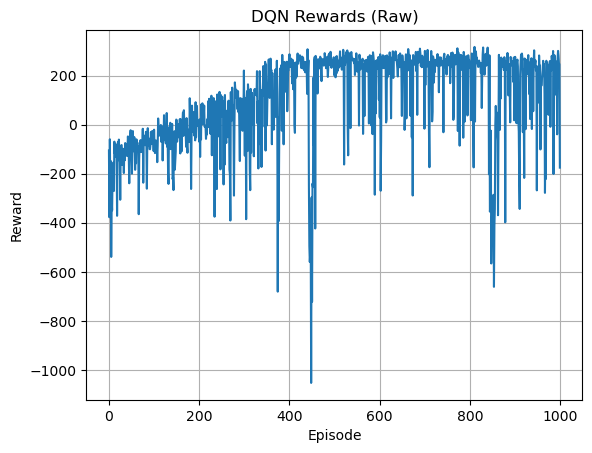

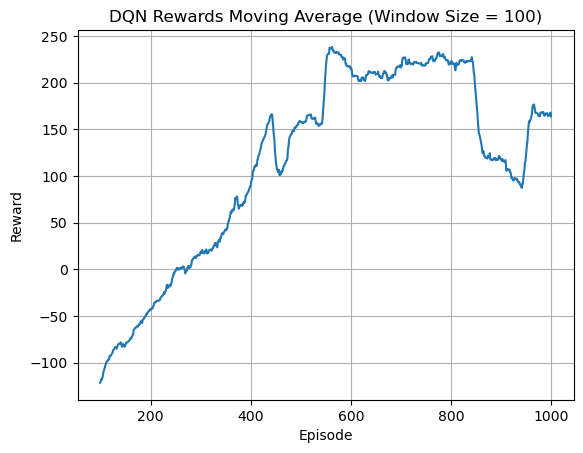

In [43]:
plt.plot(dqn_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Rewards (Raw)')
plt.grid()

window_size = 100

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

dqn_rewards_moving_avg = moving_average(dqn_rewards, window_size)
episodes = np.arange(len(dqn_rewards_moving_avg)) + window_size - 1

# Plot the moving average
plt.figure()
plt.plot(episodes, dqn_rewards_moving_avg, label='DQN Rewards (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Rewards Moving Average (Window Size = {})'.format(window_size))
plt.grid()
plt.show()


In [19]:
# handle dd
def train_ddqn(env, episodes, gamma=0.99, lr=1e-3, batch_size=64, buffer_capacity=100000, 
               epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.995, target_update_freq=10):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    
    # Initialize both the Q-network and the Target network
    q_network = DQN(input_dim, output_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    target_network = DQN(input_dim, output_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    target_network.load_state_dict(q_network.state_dict())  # Initialize target with Q-network weights
    target_network.eval()  # Target network in evaluation mode
    
    optimizer = optim.Adam(q_network.parameters(), lr=lr)
    criterion = nn.MSELoss()
    buffer = ReplayBuffer(buffer_capacity)
    epsilon = epsilon_start

    rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        total_reward = 0

        for t in range(1000):  # max steps per episode
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(q_network(state)).item()
            
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            buffer.add(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            # Train the Q-network
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = zip(*batch)

                states = torch.cat(states).float()
                actions = torch.tensor(actions).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).unsqueeze(1)
                next_states = torch.cat(next_states).float()
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                # Q-values for chosen actions
                q_values = q_network(states).gather(1, actions)

                
                with torch.no_grad():
                    # ddqn adjustments
                    next_actions = torch.argmax(q_network(next_states), dim=1, keepdim=True)
                    next_q_values = target_network(next_states).gather(1, next_actions)
                    target_q_values = rewards_batch + gamma * next_q_values * (1 - dones)

                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards.append(total_reward)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon}")

        # Update target network periodically
        if episode % target_update_freq == 0:
            target_network.load_state_dict(q_network.state_dict())

    return rewards, q_network


In [39]:
ddqn_rewards, trained_ddqn = train_ddqn(env, episodes=1000)

Episode 1, Reward: -197.1766836272772, Epsilon: 0.995
Episode 2, Reward: -91.9694914801163, Epsilon: 0.990025
Episode 3, Reward: -235.36156510957377, Epsilon: 0.985074875
Episode 4, Reward: -468.35629308694735, Epsilon: 0.9801495006250001
Episode 5, Reward: -12.9711675253659, Epsilon: 0.9752487531218751
Episode 6, Reward: -121.05390003173737, Epsilon: 0.9703725093562657
Episode 7, Reward: -281.2332288535001, Epsilon: 0.9655206468094844
Episode 8, Reward: -66.08116270888807, Epsilon: 0.960693043575437
Episode 9, Reward: -301.54018889530664, Epsilon: 0.9558895783575597
Episode 10, Reward: -115.51570295762278, Epsilon: 0.9511101304657719
Episode 11, Reward: -349.516982221346, Epsilon: 0.946354579813443
Episode 12, Reward: -26.21711097868041, Epsilon: 0.9416228069143757
Episode 13, Reward: -126.58759985583434, Epsilon: 0.9369146928798039
Episode 14, Reward: -295.58999610528684, Epsilon: 0.9322301194154049
Episode 15, Reward: -143.9860025908904, Epsilon: 0.9275689688183278
Episode 16, Rewar

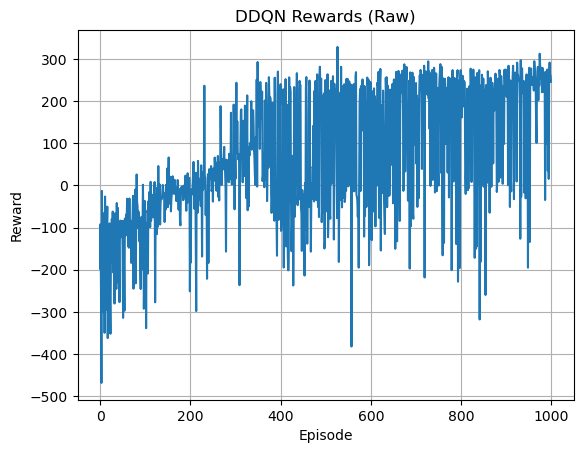

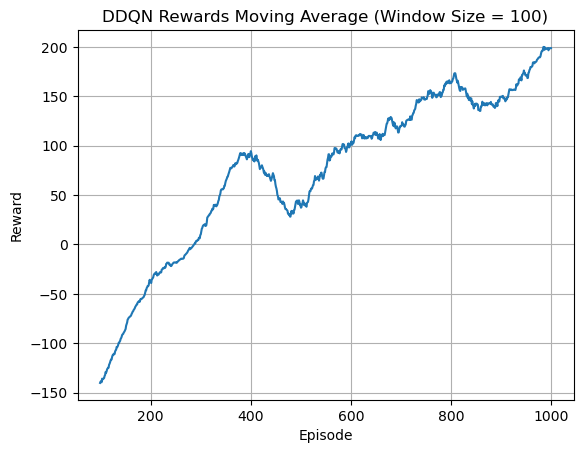

In [45]:
plt.plot(ddqn_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DDQN Rewards (Raw)')
plt.grid()

window_size = 100

ddqn_rewards_moving_avg = moving_average(ddqn_rewards, window_size)
episodes = np.arange(len(ddqn_rewards_moving_avg)) + window_size - 1

# Plot the moving average
plt.figure()
plt.plot(episodes, ddqn_rewards_moving_avg, label='DDQN Rewards (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DDQN Rewards Moving Average (Window Size = {})'.format(window_size))
plt.grid()
plt.show()

In [47]:
# Dueling dqn architechure
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU()
        )
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Single output for V(s)
        )
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)  # Outputs for A(s, a)
        )
    
    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)
        # Combine value and advantage streams
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

In [49]:
# literally vanilla but with dueling architecture
def train_dueling_dqn(env, episodes, gamma=0.99, lr=1e-3, batch_size=64, buffer_capacity=100000, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.995):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    dqn = DuelingDQN(input_dim, output_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    criterion = nn.MSELoss()
    buffer = ReplayBuffer(buffer_capacity)
    epsilon = epsilon_start

    rewards = []  # Initialize as a Python list
    for episode in range(episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        total_reward = 0
    
        for t in range(1000):  # max steps per episode
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(dqn(state)).item()
            
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            buffer.add(state, action, reward, next_state, done)
    
            state = next_state
            total_reward += reward
    
            # Train the DQN
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = zip(*batch)
    
                states = torch.cat(states).float()
                actions = torch.tensor(actions).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).unsqueeze(1)
                next_states = torch.cat(next_states).float()
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)
    
                q_values = dqn(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q_values = dqn(next_states).max(1, keepdim=True)[0]
                    target_q_values = rewards_batch + gamma * max_next_q_values * (1 - dones)
    
                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if done:
                break
    
        rewards.append(total_reward)  # Append total_reward to Python list
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon}")
    
    return rewards, dqn

In [51]:
dueling_dqn_rewards, trained_dueling_dqn = train_dueling_dqn(env, episodes=1000)

Episode 1, Reward: -263.5691853865032, Epsilon: 0.995
Episode 2, Reward: -198.6723287698486, Epsilon: 0.990025
Episode 3, Reward: -298.9173087128913, Epsilon: 0.985074875
Episode 4, Reward: -271.80673067160103, Epsilon: 0.9801495006250001
Episode 5, Reward: -93.41286607341964, Epsilon: 0.9752487531218751
Episode 6, Reward: -102.22356274612511, Epsilon: 0.9703725093562657
Episode 7, Reward: -78.58310515736518, Epsilon: 0.9655206468094844
Episode 8, Reward: -117.69241755612204, Epsilon: 0.960693043575437
Episode 9, Reward: -427.8187418199785, Epsilon: 0.9558895783575597
Episode 10, Reward: -121.91122117118391, Epsilon: 0.9511101304657719
Episode 11, Reward: -96.45874377413278, Epsilon: 0.946354579813443
Episode 12, Reward: -96.20374921467231, Epsilon: 0.9416228069143757
Episode 13, Reward: -214.03101265351154, Epsilon: 0.9369146928798039
Episode 14, Reward: -57.13344339749737, Epsilon: 0.9322301194154049
Episode 15, Reward: -273.3754229527334, Epsilon: 0.9275689688183278
Episode 16, Rewa

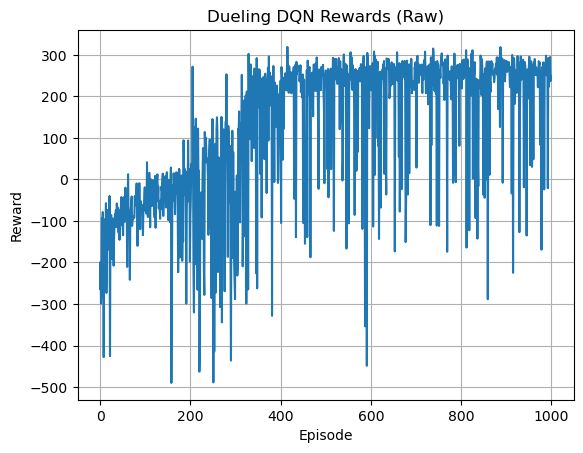

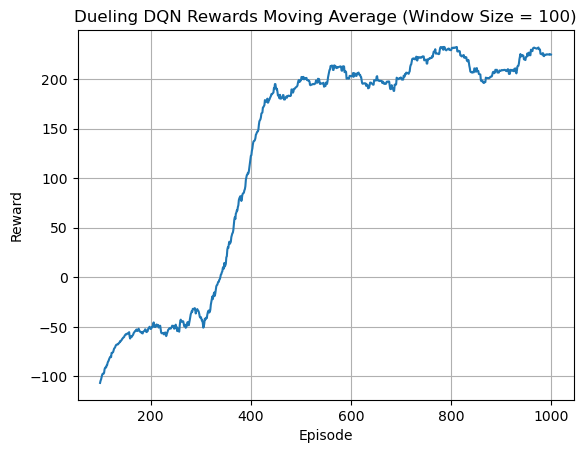

In [53]:
plt.plot(dueling_dqn_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Dueling DQN Rewards (Raw)')
plt.grid()

window_size = 100

dueling_dqn_rewards_moving_avg = moving_average(dueling_dqn_rewards, window_size)
episodes = np.arange(len(dueling_dqn_rewards_moving_avg)) + window_size - 1

# Plot the moving average
plt.figure()
plt.plot(episodes, dueling_dqn_rewards_moving_avg, label='Dueling DQN Rewards (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Dueling DQN Rewards Moving Average (Window Size = {})'.format(window_size))
plt.grid()
plt.show()

In [ ]:
# visualize performances
def select_action(state, model, epsilon=0.0):
    if random.random() < epsilon:  # Explore
        return env.action_space.sample()
    else:  # Exploit
        with torch.no_grad():
            q_values = model(state)
            action = torch.argmax(q_values).item()
        return action

def simulate(model):
    env = gym.make("LunarLander-v2", render_mode='rgb_array')
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    
    img = plt.imshow(env.render())
    for _ in range(1000):
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = select_action(state, model, epsilon=0.0)  # Greedy action
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        state = next_state
    
        if terminated or truncated:
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    
    env.close()

In [ ]:
simulate(trained_dueling_dqn)

In [ ]:
simulate(trained_dqn)

In [ ]:
simulate(trained_ddqn)